In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import query, job_config, render, register_filter, register_global
import pandas as pd

<IPython.core.display.Javascript object>

In [29]:
relevant_experiments = [
    "neurips21-cifar-centralized-tuning",
    "neurips21-cifar-gossip-reps",
    "neurips21-cifar-relaysum-grad-reps",
    "neurips21-cifar-relaysum-model-reps",
    "neurips21-cifar-d2-reps",
    "neurips21-cifar-quasi-global-reps",
    "neurips21-cifar-push-sum-reps",
]

In [30]:
data = [query("""query($experiment: String!) {
  jobs(experiment: $experiment, status: FINISHED) {
    job
    id
    status
    config {
      key
      value
    }
    annotations {
      key
      value
    }
    timeseries {
      measurement
      tags
      values
    }
  }
}""", {"experiment": experiment})["jobs"] for experiment in relevant_experiments]

In [31]:
results = []

def optimizer_name(job):
    config = job_config(job)

for experiment in data:
    for job in experiment:
        config = job_config(job)
        if job["status"] != "FINISHED":
            continue
        job_data = {
            "job_id": job["id"],
            "algorithm": config["algorithm"], 
            "non_iid_alpha": config["non_iid_alpha"], 
            "num_workers": config["distributed_world_size"], 
            "learning_rate": config["learning_rate"], 
            "momentum": config["momentum"], 
            "topology": config["topology"], 
            "learning_rate": config.get("learning_rate"), 
            "seed": config["seed"]
        }
        for series in job["timeseries"]:
            series_data = {"measurement": series["measurement"], **series["tags"]}
            if series["measurement"] not in {"accuracy", "cross_entropy"}:
                continue
            for entry in series["values"]:
                results.append({
                    **job_data,
                    **series_data,
                    "step": entry["epoch"],
                    "warm_start": config.get("optimizer_warm_start", "baseline"),
                    "starred": {x["key"]: x["value"] for x in job["annotations"]}.get("star", False),
                    "value": entry["value"],
                    "mb": entry["mb"],
                    "task": config["task"]
                })
    df = pd.DataFrame(results)

    df["non_iid_alpha"] = df.non_iid_alpha.fillna(-1)
    df

In [32]:
df = df[df.non_iid_alpha.isin([0.01, -1])]
df

,algorithm,job_id,learning_rate,mb,measurement,momentum,non_iid_alpha,num_workers,seed,split,starred,step,task,topology,value,warm_start,worker
0,all-reduce,60a4fd958062008ff1a6d430,0.1,0.000000e+00,accuracy,0.0,-1.00,16,1,test,False,0,Cifar,fully-connected,0.1000,baseline,1
1,all-reduce,60a4fd958062008ff1a6d430,0.1,3.608091e+03,accuracy,0.0,-1.00,16,1,test,False,1,Cifar,fully-connected,0.1000,baseline,1
2,all-reduce,60a4fd958062008ff1a6d430,0.1,7.216182e+03,accuracy,0.0,-1.00,16,1,test,False,2,Cifar,fully-connected,0.1318,baseline,1
3,all-reduce,60a4fd958062008ff1a6d430,0.1,1.082427e+04,accuracy,0.0,-1.00,16,1,test,False,3,Cifar,fully-connected,0.2048,baseline,1
4,all-reduce,60a4fd958062008ff1a6d430,0.1,1.443236e+04,accuracy,0.0,-1.00,16,1,test,False,4,Cifar,fully-connected,0.2141,baseline,1
5,all-reduce,60a4fd958062008ff1a6d430,0.1,1.804046e+04,accuracy,0.0,-1.00,16,1,test,False,5,Cifar,fully-connected,0.2664,baseline,1
6,all-reduce,60a4fd958062008ff1a6d430,0.1,2.886473e+04,accuracy,0.0,-1.00,16,1,test,False,8,Cifar,fully-connected,0.3314,baseline,1
7,all-reduce,60a4fd958062008ff1a6d430,0.1,4.329709e+04,accuracy,0.0,-1.00,16,1,test,False,12,Cifar,fully-connected,0.4811,baseline,1
8,all-reduce,60a4fd958062008ff1a6d430,0.1,5.772946e+04,accuracy,0.0,-1.00,16,1,test,False,16,Cifar,fully-connected,0.5651,baseline,1
9,all-reduce,60a4fd958062008ff1a6d430,0.1,7.216182e+04,accuracy,0.0,-1.00,16,1,test,False,20,Cifar,fully-connected,0.6264,baseline,1


In [34]:
ids = {"60ad60ab806200812d94c950", "60ad599d8062007389fcb5c1", "60ab8c868062005c4d8c6dad", "60ab8b7e8062005b5bf4b048", "60a4c8ef80620060bae43b9c"}
df = df[df.job_id.isin(ids)]
df

,algorithm,job_id,learning_rate,mb,measurement,momentum,non_iid_alpha,num_workers,seed,split,starred,step,task,topology,value,warm_start,worker
1760,all-reduce,60a4c8ef80620060bae43b9c,0.100,0.000000e+00,accuracy,0.9,-1.00,16,1,test,True,0,Cifar,fully-connected,0.1000,baseline,1
1761,all-reduce,60a4c8ef80620060bae43b9c,0.100,3.608091e+03,accuracy,0.9,-1.00,16,1,test,True,1,Cifar,fully-connected,0.2219,baseline,1
1762,all-reduce,60a4c8ef80620060bae43b9c,0.100,7.216182e+03,accuracy,0.9,-1.00,16,1,test,True,2,Cifar,fully-connected,0.3070,baseline,1
1763,all-reduce,60a4c8ef80620060bae43b9c,0.100,1.082427e+04,accuracy,0.9,-1.00,16,1,test,True,3,Cifar,fully-connected,0.3270,baseline,1
1764,all-reduce,60a4c8ef80620060bae43b9c,0.100,1.443236e+04,accuracy,0.9,-1.00,16,1,test,True,4,Cifar,fully-connected,0.2438,baseline,1
1765,all-reduce,60a4c8ef80620060bae43b9c,0.100,1.804046e+04,accuracy,0.9,-1.00,16,1,test,True,5,Cifar,fully-connected,0.4176,baseline,1
1766,all-reduce,60a4c8ef80620060bae43b9c,0.100,2.886473e+04,accuracy,0.9,-1.00,16,1,test,True,8,Cifar,fully-connected,0.6740,baseline,1
1767,all-reduce,60a4c8ef80620060bae43b9c,0.100,4.329709e+04,accuracy,0.9,-1.00,16,1,test,True,12,Cifar,fully-connected,0.7749,baseline,1
1768,all-reduce,60a4c8ef80620060bae43b9c,0.100,5.772946e+04,accuracy,0.9,-1.00,16,1,test,True,16,Cifar,fully-connected,0.8199,baseline,1
1769,all-reduce,60a4c8ef80620060bae43b9c,0.100,7.216182e+04,accuracy,0.9,-1.00,16,1,test,True,20,Cifar,fully-connected,0.8377,baseline,1


In [79]:
import seaborn as sns
sns.set_theme("paper")
sns.set_style("whitegrid")
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    'text.latex.preamble' : r'\usepackage{amsmath}\usepackage{amssymb}\usepackage{newtxmath}'
})
import matplotlib.ticker as mtick
colors = [sns.color_palette("tab10")[i] for i in [7, 0, 1, 9, 3]]

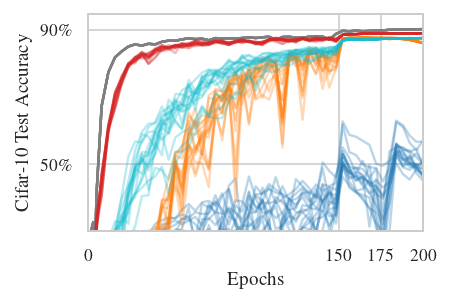

In [100]:
fig, ax = plt.subplots(figsize=(3,2))
for i, (algorithm, algorithm_name) in enumerate((("all-reduce", "All-reduce"), ("gossip", "Gossip on ring"), ("d2", "D$^2$ on ring"),  ("push-sum", "SGP on time-varying exponenial graph"), ("relaysum-model", "RelaySGD on double binary trees"))):
    for worker, data in df[df.algorithm.eq(algorithm)].groupby("worker"):
        ax.plot("step", "value", data=data, color=colors[i], alpha=0.3, linestyle=None)

ax.set_ylabel("Cifar-10 Test Accuracy");
ax.set_xlabel("Epochs");
ax.set_xticks([0, 150, 175, 200])
ax.set_yticks([.5, .9])
ax.set_xlim([0, 200])
ax.set_ylim([0.3, .95])

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

In [101]:
fig.savefig("cifar-convergence-curves.pdf", bbox_inches="tight")